In this notebook, we demonstrate how to use SimuQ to deploy Hamiltonian-based quantum algorithms. We implement and deploy the quantum algorithm for simulating quantum walk on graphs, developed in \[1\]. 

\[1\] Jiaqi Leng, Joseph Li, Yuxiang Peng, and Xiaodi Wu. Expanding hardware-efficiently manipulable Hilbert space via Hamiltonian embedding. In preparation.

# Quantum Walk on Graphs

## 1. Preliminary: classical random walk on graphs

A (discrete-time) random walk on an undirected graph $G=(V, E)$ describes a walker moving from one vertex to another via a randomly chosen edge connecting these two vertices. 
Analogously, we can formulate the continuous-time version of random walk, described by the following ordinary differential equation (ODE):

$$\dot{\rho}(t) = -L \rho(t),$$

where $\rho(t)\colon[0, T]\to \mathbb{R}^{|V|}$ is a probability distribution on the graph $G$, and $L$ is the graph Laplacian of $G$,

$$L_{jk}=\begin{cases}
  -1, & j\neq k, (j, k)\in E \\ 0, & j\neq k, (j, k)\not\in E \\ \mathrm{deg}(j), & j=k 
\end{cases}.$$

The solution to this ODE is then given by $$\rho(t)=e^{-Lt}\rho(0),$$
where $\rho(0)$ is the initial probability distribution.


## 2. Quantum walk on graphs

Mimicking the classical dynamics of random walk, we formulate the (continuous-time) quantum walk on the graph $G$. We substitute $|\psi(t)\rangle$ for the probability distribution $\rho(t)$, and upgrade the linear ODE to the Schrodinger equation

$$\frac{\mathrm{d}}{\mathrm{d}t}|\psi(t)\rangle=-iL|\psi(t)\rangle.$$

Therefore, to implement the quantum walk is equivalent to simlate the Hamiltonian $L$ on a quantum computer.

## 3. An example: 5-node chain graph

In this tutorial, we use SimuQ to demonstrate the full workflow of simulating the quantum walk on a 5-node chain graph,
<div> <img src="imgs/walk_chain.png" width="300"/> </div> 
The graph Laplacian of this chain graph is a tri-diagonal matrix (see the following code block).

In [1]:
import numpy as np

def mat_print(M, width=7):
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if abs(M[i, j]) < 1e-5:
                print(" " * width, end="")
            elif M.dtype == np.dtype("complex128") and abs(M[i, j].imag) < 1e-5:
                print("{f: {w}}".format(f=M[i, j].real, w=width), end="")
            else:
                print("{f: {w}}".format(f=M[i, j], w=width), end="")
        print()

N, T = 5, 2
E = np.zeros((N, N))
for j in range(N - 1):
    E[j, j + 1] = 1
A = E + E.transpose()
L_chain = np.diag(sum(A)) - A
print("Graph Laplacian of the 5-node chain graph:")
mat_print(L_chain)

Graph Laplacian of the 5-node chain graph:
    1.0   -1.0                     
   -1.0    2.0   -1.0              
          -1.0    2.0   -1.0       
                 -1.0    2.0   -1.0
                        -1.0    1.0


## Idea 1:  direct simulation of the Hamiltonian $L$

Naively, we can decompose the Hamiltonian $L$ into Pauli operators. This approach is called the *standard binary representation* of the Hamiltonian. Specifically, we may calculate the matrix $L$ and its Pauli decomposition

$$L=\sum\nolimits_{P\in\mathrm{Pauli}^{\otimes N}}\mathrm{tr}\{LP\} P.$$ 

Here $\mathrm{Pauli}=\{I, X, Y, Z\}$ is the set of Pauli matrices and $\mathrm{tr}$ is the trace.

With the Hamiltonian represented as a list of Pauli operators, we may employ some standard quantum algorithms (e.g., Trotter-Suzuki formula) to simulate the quantum evolution generated by $L$.

In the following code block, we compute the Pauli decomposition of the matrix

$$H = \begin{bmatrix} L & 0 \\ 0 & 0 \end{bmatrix}.$$

Note that we pad a 3-by-3 zero matrix in the lower right corner to make $H$ a 3-qubit operator.

In [2]:
from qiskit.quantum_info import SparsePauliOp
H = np.zeros((8, 8))
H[:5, :5] = L_chain
SparsePauliOp.from_operator(H)

SparsePauliOp(['III', 'IIX', 'IXX', 'IYY', 'XXX', 'XYY', 'YXY', 'YYX', 'ZII', 'ZIX', 'ZIZ', 'ZXX', 'ZYY', 'ZZI', 'ZZZ'],
              coeffs=[ 1.  +0.j, -0.5 +0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
 -0.25+0.j, -0.25+0.j,  0.75+0.j, -0.5 +0.j, -0.25+0.j, -0.25+0.j,
 -0.25+0.j, -0.25+0.j, -0.25+0.j])

It turns out that the standard binary representation of $L$ involves more than **10** different types of Pauli operators! We do not know any analog quantum computer whose **native** Hamiltonian matches this sophisticated pattern. On a digital quantum computer, it may be feasible to simulate this Hamiltonian by doing a long sequence of Trotter steps. However, it is generally very expensive to implement a quantum circuit that exponentiates a multi-site interaction terms (such as $YXY$).

## Idea 2: simulate $L$ via Hamiltonian embedding

The idea of Hamiltonian embedding is to reduce the complexity of the Hamiltonian by introducing a larger Hilbert space (i.e., using more qubits).

As we have seen, the graph Laplacian $L$ can be embedded into a $4$-qubit operator:

$$H'=gH_{\mathrm{pen}}+Q=g\left(Z_1+(-1)^{N-1} Z_{N-1}+\sum\nolimits_{j=1}^{N-2}Z_jZ_{j+1}\right)+\left(\hat{n}_1+(-1)^{N-1}\hat{n}_{N-1}-\sum\nolimits_{j=1}^{N-1} X_j\right).$$

Here, $H_{\mathrm{pen}}$ is the so-called *penalty Hamiltonian*, and $g$ is a penalty coefficient. 
The Hamiltonian $H_{\mathrm{pen}}$ has 5 degenerate ground states:

$$|0101\rangle, |1101\rangle, |1001\rangle, |1011\rangle, |1010\rangle.$$

Let $\mathcal{S}$ be the ground-energy subspace of $H_{\mathrm{pen}}$, we can prove that

$$\left(e^{-iH't}\right)\big|_{\mathcal{S}} = e^{-iLt} ~~\text{as}~~ g \to \infty.$$

In practice, we choose $g \sim |V|$ for good simulation precision.

Now that the embedding Hamiltonian $H'$ only involves $X$, $Z$, and $ZZ$ terms, we may simulate this Hamiltonian on the QuEra machine.

First, we program the embedding Hamiltonian $H'$ using SimuQ.

In [3]:
from simuq import QSystem, Qubit

def chain_walk(N, T, g, scaler=1):
    walk = QSystem()
    N1 = N - 1
    q = [Qubit(walk) for _ in range(N1)]
    nhat = [(q[j].Z - q[j].I) / 2 for j in range(N1)]
    
    # Penalty Hamiltonian
    sgnN1 = -1 if N1 % 2 == 1 else 1
    Hpen = q[0].Z + sgnN1 * q[N1 - 1].Z
    for j in range(N1 - 1):
        Hpen += q[j].Z * q[j + 1].Z
    
    # Encoding Hamiltonian 
    Q = - nhat[0] - sgnN1 * nhat[N1 - 1]
    for j in range(N1):
        Q -= q[j].X
        
    H = g * Hpen + Q
    walk.add_evolution(H * scaler, T / scaler)
    return walk

The Hamiltonian $H'$ for a quantum walk on a 5-node chain graph is constructed in 2 lines:

In [4]:
g = N - 1
walk = chain_walk(N, T, g)

The target Hamiltonian $L$ is embedding in the Hamiltonian $H'$ in the sense that

$$\left(H'\right)\big|_{\mathcal{S}} = L,$$

where the subspace

$$\mathcal{S} = \mathrm{span}\{|5\rangle, |13\rangle, |9\rangle, |11\rangle, |10\rangle\}$$

is the ground-energy subspace of the penalty Hamiltonian $H_{\mathrm{pen}}$.

We now use SimuQ to verify that the target Hamiltonian $L$ is indeed embedded in this subspace.

In [5]:
from simuq.qutip import QuTiPProvider

qtpp = QuTiPProvider()
qtpp.compile(walk)

Compiled.


In [6]:
def gen_encoding(N):
    s0 = 0
    for i in range(N - 1):
        if i % 2 == 0:
            s0 ^= 1 << i
    s = [s0]
    for i in range(1, N):
        s.append(s[i - 1] ^ 1<<(N - 1 - i))
    return s

def rearrange_encoding(M, N, s):
    aug_s = [v for v in s]
    for i in range(1 << (N - 1)):
        if i not in aug_s:
            aug_s.append(i)
    return M[:, aug_s][aug_s, :]

M = qtpp.evaluate_Hamiltonian(t=0)
s = gen_encoding(N)

print("Hamiltonian restricted to the embedding subspace:")
mat_print(M.full()[:, s][s, :])
print("=" * 100)
print("Full Hamiltonian:")
mat_print(rearrange_encoding(M.full(), N, s))

Hamiltonian restricted to the embedding subspace:
  -11.0   -1.0                     
   -1.0  -10.0   -1.0              
          -1.0  -10.0   -1.0       
                 -1.0  -10.0   -1.0
                        -1.0  -11.0
Full Hamiltonian:
  -11.0   -1.0                               -1.0                 -1.0          -1.0                            
   -1.0  -10.0   -1.0                                                                         -1.0          -1.0
          -1.0  -10.0   -1.0                 -1.0                                      -1.0                     
                 -1.0  -10.0   -1.0                        -1.0                                             -1.0
                        -1.0  -11.0                 -1.0                               -1.0          -1.0       
                                      20.0   -1.0   -1.0          -1.0                 -1.0                     
   -1.0          -1.0                 -1.0    5.0          -1.0           

We examine the dynamics of quantum walk where the walker starts from the vertex in the middle (i.e., the 3rd node), which is $|1001\rangle = |9\rangle$. 

We may send in the initial state to the QuTiP provider. Enumerating the timesteps, we may observe the propagation of the walker. Notice that the off-diagonal terms in $H$ is not zero in the Hamiltonian embedding, there will be leakage to non-encoding subspace. We manually post-select those cases.

Quantum walk on the 5-node chain graph:


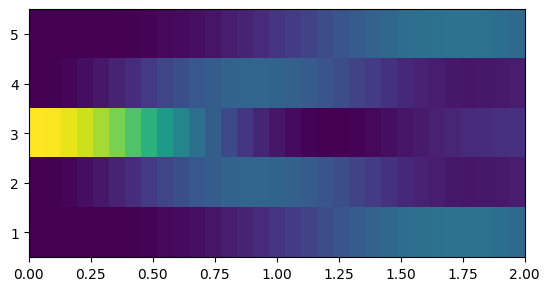

In [7]:
import qutip as qtp
import matplotlib.pyplot as plt

def draw_results(steps, results_list, show_enc_prob=False):
    rev_map = dict(zip(s, range(len(s))))
    distr = np.zeros((N, steps + 1))
    in_enc_space = np.zeros(steps + 1)
    for i, res in enumerate(results_list):
        counts = [0.] * N
        for k in res.keys():
            deck = int(k, 2)
            if deck in rev_map:
                counts[rev_map[deck]] += res[k]
        in_enc_space[i] = sum(counts)
        for j in range(N):
            distr[j, i] = counts[j] / in_enc_space[i]
    if show_enc_prob:
        print("Population in encoding subspace:", sum(in_enc_space) / len(in_enc_space))
    if steps != 0:
        plt.imshow(distr, extent=[0, T, 0.5, N + 0.5], aspect=0.2)
    else:
        plt.bar(np.arange(1, N+1), distr[:,0])

steps = 30
ket9 = qtp.basis(1 << (N - 1), s[(N - 1) // 2])
timestep = np.linspace(0, T, steps + 1)
results_list = []
for t in timestep:
    walk = chain_walk(N, t, g)
    qtpp.compile(walk, initial_state=ket9, verbose=-1)
    qtpp.run(verbose=-1)
    results_list.append(qtpp.results())

print("Quantum walk on the 5-node chain graph:")
draw_results(steps, results_list)

## Deploying Hamiltonian embedding on QuEra devices

The above Hamiltonian $H$ only involves Pauli operators $X$, $Z$, and $ZZ$. This means we can simulate this Hamiltonian using Rydberg atoms (e.g., the QuEra machines). We access their devices via Braket providers.

In [8]:
from simuq.braket import BraketProvider

bp = BraketProvider()

In [9]:
walk = chain_walk(N, T=2, g=g)
bp.compile(walk, provider="quera", device="Aquila", aais="rydberg1d_global", tol=2)

### Step 1: initial state preparation

To initialize the quantum system to the state $|1001\rangle$, we employ a quantum optimal control technique developed in [Differentiable Analog Quantum Computing for Optimization and Control](https://arxiv.org/abs/2210.15812) to learn global laser control pulses that generate $|1001\rangle$ with high fidelity. For the software and more technical discussions, we refer the readers to [Bloqade Control](https://github.com/jiaqileng/diff-analog-rydberg).

Here we import the pre-trained state preparation pulses from NPZ files. The state preparation fidelity is 98%.

In [10]:
def load_state_prep(file):
    state_prep_pulse = np.load(file)
    sp_omega = state_prep_pulse.f.omega
    sp_delta = np.clip(state_prep_pulse.f.delta, -125, 125)
    sp_phi = np.zeros_like(sp_omega)
    sp_times = state_prep_pulse.f.times
    diff_sp_times = [sp_times[i + 1] - sp_times[i] for i in range(len(sp_times) - 1)]
    return {"times": diff_sp_times, "omega": sp_omega, "delta": sp_delta, "phi": sp_phi, "timeseries": sp_times}

state_prep = load_state_prep("pulses/chain_state_prep_4_qubit_ket9_high_fidelity.npz")

### Step 2: build Rydberg Hamiltonian model using SimuQ

In [11]:
walk = chain_walk(N, T=2, g=g)
bp.compile(walk, provider="quera", device="Aquila", aais="rydberg1d_global", tol=5, state_prep=state_prep, no_main_body=True)

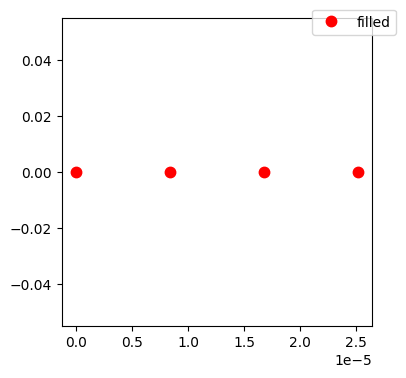

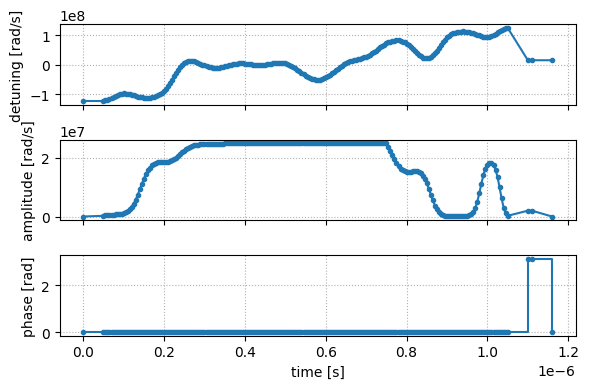

In [12]:
bp.visualize()

In [13]:
bp.run(shots=1000, on_simulator=True)

Submitted.


In [14]:
print(bp.results())

{'0000': 0.001, '0001': 0.003, '0011': 0.003, '0101': 0.005, '0110': 0.003, '1000': 0.002, '1001': 0.976, '1010': 0.003, '1100': 0.001, '1101': 0.003}


Population in encoding subspace: 0.9611290322580645


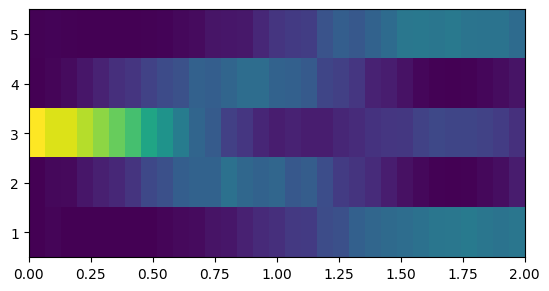

In [15]:
results_list = [bp.results()]
for t in timestep:
    if t == 0:
        continue
    walk = chain_walk(N, t, g)
    bp.compile(walk, provider="quera", device="Aquila", aais="rydberg1d_global", tol=5, state_prep=state_prep)
    bp.run(shots=1000, on_simulator=True, verbose=-1)
    results_list.append(bp.results())
draw_results(steps, results_list, True)

We may then execute the algorithm on real devices. However, hardware restrictions limit the precision of state preparation: (1) the time intervals of pulses are wide ($\geq 0.05\mu s$); (2) the slew rates and ranges of parameters are much limited. We generate another pulse preparing $|9\rangle$ with 84% fidelity in ideal cases and can be executed on Aquila, while the performance tests are left for practice of users.

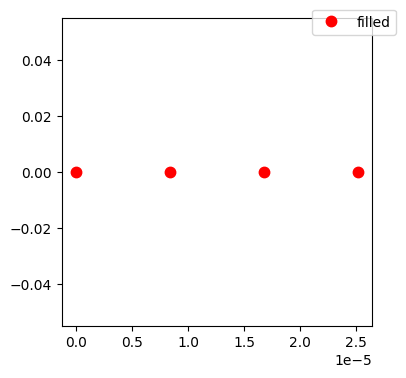

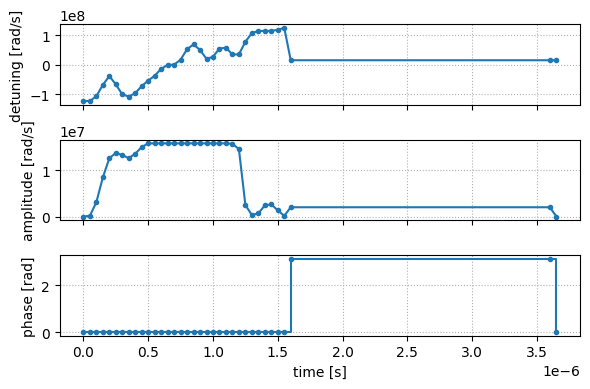

In [16]:
state_prep = load_state_prep("pulses/chain_state_prep_4_qubit_ket9_practical.npz")
state_prep_lowres = {}
for key in state_prep.keys():
    state_prep_lowres[key] = [state_prep[key][j] for j in range(0, len(state_prep[key]), 10)]
timeseries = state_prep_lowres["timeseries"]
state_prep_lowres["times"] = [timeseries[j + 1] - timeseries[j] for j in range(len(timeseries) - 1)]

bp.compile(walk, provider="quera", device="Aquila", aais="rydberg1d_global", tol=5, state_prep=state_prep_lowres)
bp.visualize()

In [17]:
bp.run(shots = 1000)

Submitted.
Task arn:  arn:aws:braket:us-east-1:795824654075:quantum-task/35e64971-346d-44b6-8493-a9832c8d6d69
Task status:  QUEUED


Population in encoding subspace: 0.8160000000000001


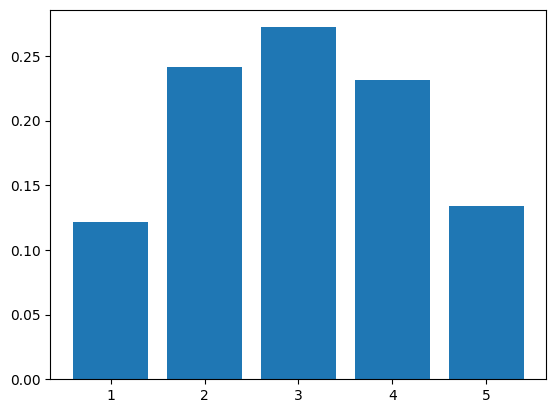

In [18]:
#results_list = [bp.results()]
results_list = [bp.results("arn:aws:braket:us-east-1:795824654075:quantum-task/35e64971-346d-44b6-8493-a9832c8d6d69")]
draw_results(0, results_list, True)

## Deploy Hamiltonian embedding on IonQ devices

We can similarly deploy the Hamitlonian $H$ on IonQ devices. For state preparation on IonQ devices, we simply apply two $X$ gates to generate $|9\rangle=|1001\rangle.$ 

Population in encoding subspace: 0.9252290322580646


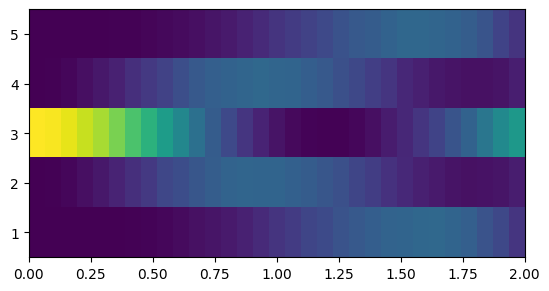

In [19]:
from simuq.braket import BraketIonQCircuit

state_prep = BraketIonQCircuit(N-1).gpi(0, 0).gpi(3, 0)

timestep = np.linspace(0, T, steps + 1)
results_list = []
for t in timestep:
    walk = chain_walk(N, t, g)
    bp.compile(walk, provider="ionq", device="Aria-2", aais="heisenberg", trotter_num=6, state_prep=state_prep, verbose = -1)
    bp.run(shots=10000, on_simulator=True, verbose=-1)
    results_list.append(bp.results())

draw_results(steps, results_list, True)

In real device execution, errors will significantly induce leakage outside of the encoding subspace. Further details on how to reduce the effects of errors are illustrated in \[1\] via other embedding techniques, although may not be executable on QuEra devices.

## Deploy Hamiltonian embedding on IBM devices
We can similarly deploy the Hamitlonian $H$ on IBM devices. For state preparation on IBM devices, we simply apply two $X$ gates to generate $|9\rangle=|1001\rangle.$ 

In [20]:
from simuq.ibm import IBMProvider

ibm = IBMProvider(from_file="../../qiskit_API_token", hub="ibm-q", group="open", project="main")

In [21]:
from qiskit import QuantumCircuit
state_prep = QuantumCircuit(4)
state_prep.x(0)
state_prep.x(3)

The simulation of IBM on ideal simulators generates the same results as IonQ's ideal simulation. Since currently Qiskit simulator is cloud-based, we only run 5 steps as an illustration.

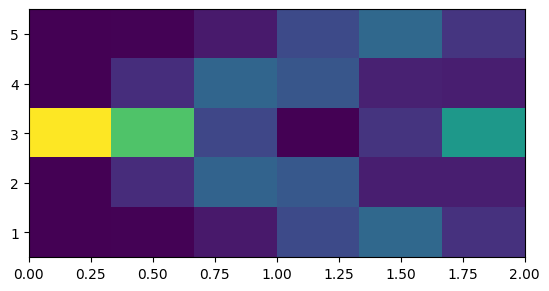

In [22]:
steps = 5
timestep = np.linspace(0, T, steps + 1)

results_list = []
for t in timestep:
    walk = chain_walk(N, t, g)
    ibm.compile(walk, backend="ibmq_jakarta", trotter_num=6, use_pulse=False, state_prep=state_prep, verbose = -1)
    ibm.run(on_simulator=True, shots=8192, verbose = -1)
    results_list.append(ibm.results(on_simulator=True))

draw_results(steps, results_list)